In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

In [2]:
# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Preprocessing
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, OrdinalEncoder, TargetEncoder, FunctionTransformer
from sklearn.model_selection import GridSearchCV, KFold
from category_encoders import CatBoostEncoder

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

#models
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, StackingClassifier
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier, Pool, cv
from sklearn.linear_model import Lasso

from sklearn.feature_selection import f_regression

# Metrics
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error, mean_squared_log_error, root_mean_squared_error

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import LabelEncoder

In [3]:
from my_module import MyTransformer, GroupMedianImputer, SomeCustomShit

Читаем данные

In [4]:
df = pd.read_csv('../data/raw/train.csv')

Проводим первичный анализ

In [5]:
df.shape

(1460, 81)

In [6]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

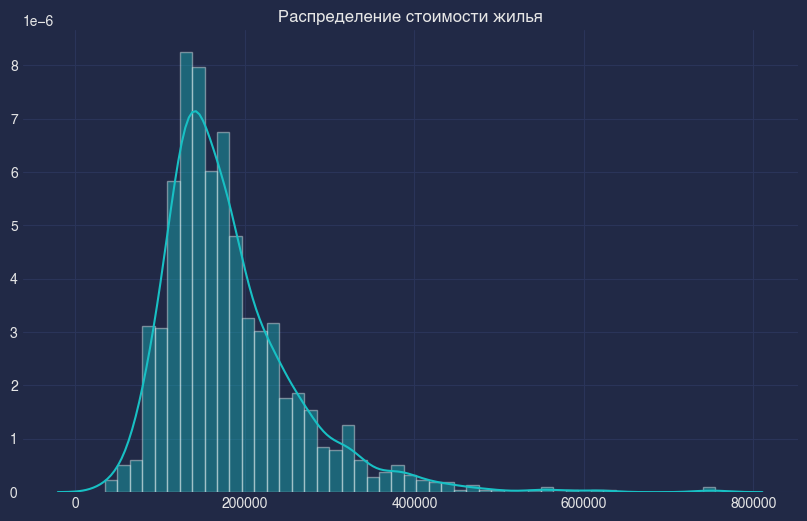

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.distplot(x=df['SalePrice'],ax=ax)

ax.set(title='Распределение стоимости жилья', xlabel='', ylabel='');

In [10]:
# делим на выборки
X, y = df.drop('SalePrice', axis=1), df['SalePrice']

x1 = pd.read_csv('../data/raw/test.csv')

X = pd.concat([X, x1], axis=0)

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
na_counts = X.isna().sum()
na_counts[na_counts > 0]

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType      1766
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

In [12]:
# разбираемся с пропусками

columns_to_drop = ['Id', 'Utilities']

columns_to_fillna_with_0 = ['MasVnrArea', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']

columns_to_fillna_with_no = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'Functional', 'MSSubClass']

columns_to_fillna_mode = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']

imputer = ColumnTransformer(
    transformers=[
        ('drop', 'drop', columns_to_drop), 
        ('fill_mode', SimpleImputer(strategy='most_frequent'), columns_to_fillna_mode),
        ('fill_0', SimpleImputer(strategy='constant', fill_value=0), columns_to_fillna_with_0),
        ('fill_no', SimpleImputer(strategy='constant', fill_value='No'), columns_to_fillna_with_no)
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
)

In [13]:
custom_median = ColumnTransformer(
    transformers=[
        ('fill_street_median', GroupMedianImputer(groupby_col='Neighborhood', target_col='LotFrontage'), ['Neighborhood', 'LotFrontage'])
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
)

In [14]:
X.drop(columns_to_drop, axis=1, inplace=True)

In [15]:
trans = SomeCustomShit()
trans0 = MyTransformer()

In [16]:
X = trans0.fit_transform(X)
X = trans.fit_transform(X)

In [17]:
# кодировка / нормировка

label_encoding_columns = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 'MoSold']

standard_scaler_columns = X.select_dtypes(exclude='object').columns.tolist()

scaler_and_encoder = ColumnTransformer(
    [
        ('label_encoding_columns', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), label_encoding_columns),
        ('scaling_num_columns', StandardScaler(), standard_scaler_columns)
    ],
    verbose_feature_names_out = False,
    remainder=OneHotEncoder(handle_unknown='ignore', sparse_output=False)
)

In [18]:
scaler_and_encoder_1 = ColumnTransformer(
    [
        ('scaling_num_columns', StandardScaler(), label_encoding_columns)
    ],
    verbose_feature_names_out = False,
    remainder='passthrough'
)

In [19]:
preprocessor = Pipeline(
    [
        ('custom_transformer', MyTransformer()),
        ('imputer', imputer),
        ('custom median', custom_median),
        ('custom fe', SomeCustomShit()),
        ('scaler_and_encoder', scaler_and_encoder),
        ('norm_labers', scaler_and_encoder_1), 
    ]
)

In [20]:
import joblib

joblib.dump(preprocessor, '../models/preprossesor.pkl')

['../models/preprossesor.pkl']

In [21]:
X, y = df.drop('SalePrice', axis=1), df['SalePrice']

df.drop(df[(df['OverallQual'] <5 ) & (df['SalePrice'] > 200000)].index, inplace=True)
df.drop(df[(df['GrLivArea'] > 4500) & (df['SalePrice'] < 300000)].index, inplace=True)
df.reset_index(drop=True, inplace=True)

x1 = pd.read_csv('../data/raw/test.csv')

X = pd.concat([X, x1], axis=0)


preprocessor.fit(X)

Pipeline(steps=[('custom_transformer', MyTransformer()),
                ('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['Id', 'Utilities']),
                                                 ('fill_mode',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['MSZoning', 'Electrical',
                                                   'KitchenQual', 'Exterior1st',
                                                   'Exterior2nd', 'SaleType']),
                                                 ('fill_0',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['...
                                                  StandardScaler(),
                                                  ['FireplaceQu', 'BsmtQual',
                                                   'BsmtCond', 'GarageQual',
                                                   'GarageCond', 'ExterQual',
                                                   'ExterCond', 'HeatingQC',
                                                   'PoolQC', 'KitchenQual',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Functional',
                                                   'Fence', 'BsmtExposure',
                                                   'GarageFinish', 'LandSlope',
                                                   'LotShape', 'PavedDrive',
                                                   'Street', 'Alley',
                                                   'CentralAir', 'MSSubClass',
                                                   'OverallCond', 'MoSold'])],
                                   verbose_feature_names_out=False))])

In [22]:
X_trans = preprocessor.transform(X)

In [23]:
# X.shape

In [24]:
# df = pd.concat([X, y], axis=1)

In [25]:
model = CatBoostRegressor(verbose=False)

ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

In [26]:
# делим на выборки
df = pd.read_csv('../data/raw/train.csv')

In [27]:
# df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<300000)].index)

In [28]:
X, y = df.drop('SalePrice', axis=1), df['SalePrice']


# x1 = pd.read_csv('../data/raw/test.csv')
# 
# X = pd.concat([X, x1], axis=0)

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
y_log = np.log(y)

In [30]:
X.shape

(1460, 80)

In [31]:
# X = pd.concat([X, x1], axis=0)

In [32]:
ml_pipeline.fit(X, y_log)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('custom_transformer', MyTransformer()),
                                 ('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('drop',
                                                                   'drop',
                                                                   ['Id',
                                                                    'Utilities']),
                                                                  ('fill_mode',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['MSZoning',
                                                                    'Electrical',
                                                                    'KitchenQual',
                                                                    'Exterior1st',
                                                                    'Exterior2nd',
                                                                    'SaleType']),
                                                                  ('fill_0',
                                                                   SimpleImputer(fill...
                                                                    'GarageCond',
                                                                    'ExterQual',
                                                                    'ExterCond',
                                                                    'HeatingQC',
                                                                    'PoolQC',
                                                                    'KitchenQual',
                                                                    'BsmtFinType1',
                                                                    'BsmtFinType2',
                                                                    'Functional',
                                                                    'Fence',
                                                                    'BsmtExposure',
                                                                    'GarageFinish',
                                                                    'LandSlope',
                                                                    'LotShape',
                                                                    'PavedDrive',
                                                                    'Street',
                                                                    'Alley',
                                                                    'CentralAir',
                                                                    'MSSubClass',
                                                                    'OverallCond',
                                                                    'MoSold'])],
                                                    verbose_feature_names_out=False))])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x1798d2a50>)])

In [33]:
X_test = pd.read_csv('../data/raw/test.csv')

In [34]:
joblib.dump(ml_pipeline, '../models/cb_pipeline.pkl')

['../models/cb_pipeline.pkl']

In [35]:
ans = np.exp((ml_pipeline.predict(X_test)))

In [36]:
result_df = pd.DataFrame({
    'Id': X_test['Id'],
    'SalePrice': ans
})

In [37]:
result_df.to_csv('../data/processed/fckme66_sub.csv', index=False)

In [38]:
df = pd.read_csv('../data/raw/train.csv')


# Remove outliers
# df.drop(df[(df['OverallQual'] <5 ) & (df['SalePrice'] > 200000)].index, inplace=True)
# df.drop(df[(df['GrLivArea'] > 4500) & (df['SalePrice'] < 300000)].index, inplace=True)
# df.reset_index(drop=True, inplace=True)

X, y = df.drop('SalePrice', axis=1), df['SalePrice']

In [39]:
X_prep = preprocessor.fit_transform(X)

In [40]:
df_prep = pd.concat([X_prep, y], axis=1)

In [41]:
columns_with_low_correlation = []
correlation_with_y= df_prep.corr()['SalePrice']
columns_with_low_correlation = correlation_with_y[correlation_with_y.abs() < 0.05].index.tolist()

In [42]:
df_prep.drop(columns_with_low_correlation, axis=1, inplace=True)

In [43]:
X, y = df_prep.drop('SalePrice', axis=1), df['SalePrice']

In [44]:
# всё ему важное блин)

pd.Series(dict(zip(X.columns, f_regression(X, y)[1]))).sort_values()

OverallQual              2.185675e-313
GrLivArea                4.518034e-223
Total_sqr_footage        1.497662e-222
GarageCars               2.498644e-169
ExterQual                6.424468e-167
                             ...      
Exterior2nd_Plywood       4.311919e-02
Exterior1st_WdShing       4.994349e-02
Exterior1st_BrkComm       5.018198e-02
LandSlope                 5.068585e-02
SaleCondition_AdjLand     5.283328e-02
Length: 132, dtype: float64

In [45]:
lasso = Lasso(alpha= 0.4)
lasso.fit(X, y)

Lasso(alpha=0.4)

In [46]:
lasso_list = pd.Series(dict(zip(X.columns, lasso.coef_))).sort_values(key=lambda x: abs(x), ascending=False)

In [47]:
columns_with_low_lasso = lasso_list[lasso_list.abs() < 500].index.tolist()

In [48]:
columns_with_low_lasso

['Neighborhood_NAmes',
 'YearRemodAdd',
 'LotConfig_Inside',
 'Alley',
 'Fence',
 'EnclosedPorch',
 'MSZoning_RL',
 'Exterior2nd_CmentBd']

In [49]:
# выкидываем херню

drop_that_shit = ColumnTransformer(
    transformers=[
        ('drop', 'drop', columns_with_low_lasso)
    ],
    verbose_feature_names_out=False,
    remainder='passthrough'
)

In [50]:
new_pipeline = Pipeline(
    [
        ('pre', preprocessor),
        ('fe', drop_that_shit),
        ('model', model)
    ]
)

In [51]:
X.shape

(1460, 132)

In [52]:
# X_test = pd.read_csv('../data/raw/test.csv')
# ans = np.exp((new_pipeline.predict(X_test)))
# result_df = pd.DataFrame({
#     'Id': X_test['Id'],
#     'SalePrice': ans
# })
# result_df.to_csv('../data/processed/anotherrrr_sub.csv', index=False)

NotFittedError: This ColumnTransformer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [53]:
prep_pipeline = Pipeline(
    [
        ('pre', preprocessor),
        # ('fe', drop_that_shit),
    ]
)

In [56]:
df = pd.read_csv('../data/raw/train.csv')


X, y = df.drop('SalePrice', axis=1), df['SalePrice']


preprocessor.fit(X)

Pipeline(steps=[('custom_transformer', MyTransformer()),
                ('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['Id', 'Utilities']),
                                                 ('fill_mode',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['MSZoning', 'Electrical',
                                                   'KitchenQual', 'Exterior1st',
                                                   'Exterior2nd', 'SaleType']),
                                                 ('fill_0',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['...
                                                  StandardScaler(),
                                                  ['FireplaceQu', 'BsmtQual',
                                                   'BsmtCond', 'GarageQual',
                                                   'GarageCond', 'ExterQual',
                                                   'ExterCond', 'HeatingQC',
                                                   'PoolQC', 'KitchenQual',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'Functional',
                                                   'Fence', 'BsmtExposure',
                                                   'GarageFinish', 'LandSlope',
                                                   'LotShape', 'PavedDrive',
                                                   'Street', 'Alley',
                                                   'CentralAir', 'MSSubClass',
                                                   'OverallCond', 'MoSold'])],
                                   verbose_feature_names_out=False))])

In [57]:
y = np.log(y)

In [58]:
from sklearn.kernel_ridge import KernelRidge
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

catboost = CatBoostRegressor(verbose=False)

svr = SVR(C= 20, epsilon= 0.008, gamma=0.0003)

GBoost = GradientBoostingRegressor(n_estimators=3000, random_state =42)

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=42))


model = StackingCVRegressor(regressors=(KRR, catboost, GBoost, svr),
                                meta_regressor=lasso,
                                use_features_in_secondary=True)

svr_pipeline = Pipeline(
    [
        ('pre', preprocessor),
        # ('fe', drop_that_shit),
        ('fckthatna', SimpleImputer(strategy='constant', fill_value=0)),
        ('model', model)
    ]
)


In [59]:
svr_pipeline.fit(X, y)

Pipeline(steps=[('pre',
                 Pipeline(steps=[('custom_transformer', MyTransformer()),
                                 ('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('drop',
                                                                   'drop',
                                                                   ['Id',
                                                                    'Utilities']),
                                                                  ('fill_mode',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['MSZoning',
                                                                    'Electrical',
                                                                    'KitchenQual',
                                                                    'Exterior1st',
                                                                    'Exterior2nd',
                                                                    'SaleType']),
                                                                  ('fill_0',
                                                                   SimpleImputer(fill_value=0,...
                 StackingCVRegressor(meta_regressor=Pipeline(steps=[('robustscaler',
                                                                     RobustScaler()),
                                                                    ('lasso',
                                                                     Lasso(alpha=0.0005,
                                                                           random_state=42))]),
                                     regressors=(KernelRidge(alpha=0.6,
                                                             coef0=2.5,
                                                             degree=2,
                                                             kernel='polynomial'),
                                                 <catboost.core.CatBoostRegressor object at 0x314604650>,
                                                 GradientBoostingRegressor(n_estimators=3000,
                                                                           random_state=42),
                                                 SVR(C=20, epsilon=0.008,
                                                     gamma=0.0003)),
                                     use_features_in_secondary=True))])

In [60]:
X_test = pd.read_csv('../data/raw/test.csv')

In [67]:
ans0 = np.exp((svr_pipeline.predict(X_test)))

In [62]:
ans1 = np.exp((ml_pipeline.predict(X_test)))

In [74]:
ans = 0.5 * ans0 + 0.5 * ans1

In [65]:
# joblib.dump(svr_pipeline, '../models/stacking_pipeline.pkl')

['../models/stacking_pipeline.pkl']

In [73]:
result_df = pd.DataFrame({
    'Id': X_test['Id'],
    'SalePrice': ans
})

result_df.to_csv('../data/processed/fckmelast3_sub.csv', index=False)

In [ ]:
pred_combo = np.exp((svr_pipeline.predict(X_test)))

In [ ]:
pred_cat = np.exp((ml_pipeline.predict(X_test)))

In [ ]:
model = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

lgb_pipeline = Pipeline(
    [
        ('pre', preprocessor),
        ('model', model)
    ]
)

In [ ]:
lgb_pipeline.fit(X_train, y_train_log)

In [ ]:
pred_lgb = np.exp((lgb_pipeline.predict(X_test)))

In [ ]:
model = SVR(C= 20, epsilon= 0.008, gamma=0.0003)

sv_pipeline = Pipeline(
    [
        ('pre', preprocessor),
        ('model', model)
    ]
)
sv_pipeline.fit(X_train, y_train_log)

In [ ]:
pred_sv = np.exp((lgb_pipeline.predict(X_test)))

In [ ]:
model = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

dt_pipeline = Pipeline(
    [
        ('pre', preprocessor),
        ('model', model)
    ]
)
dt_pipeline.fit(X_train, y_train_log)

In [ ]:
pred_dt = np.exp((dt_pipeline.predict(X_test)))

In [ ]:
blender = 0.3 * pred_combo + 0.3 * pred_cat + 0.2 * pred_lgb + 0.2 * pred_sv + 0.1 * pred_dt

In [ ]:
X_test = pd.read_csv('../data/raw/test.csv')
ans = blender
result_df = pd.DataFrame({
    'Id': X_test['Id'],
    'SalePrice': ans
})
result_df.to_csv('../data/processed/last_sub.csv', index=False)